# seq2seq
本例使用tensorflow的seq2seq实现输入一组单词输出其排序后的结果

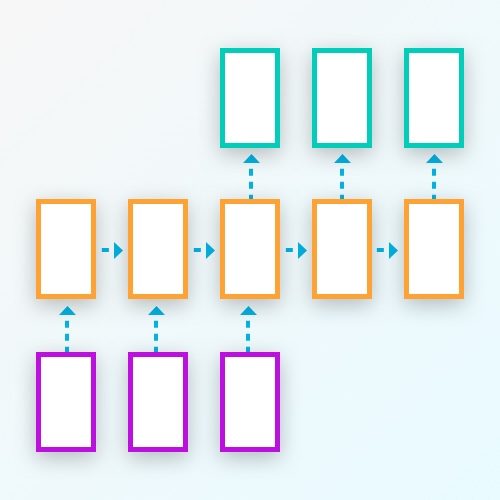

### 获取数据

In [1]:
import helper

source_path = 'data/letters_source.txt'
target_path = 'data/letters_target.txt'

source_sentences = helper.load_data(source_path)
target_sentences = helper.load_data(target_path)

In [2]:
source_sentences[:50].split('\n')#源数据

['bsaqq',
 'npy',
 'lbwuj',
 'bqv',
 'kial',
 'tddam',
 'edxpjpg',
 'nspv',
 'huloz',
 '']

In [3]:
target_sentences[:50].split('\n')#target,可以看出是排序后的结果

['abqqs',
 'npy',
 'bjluw',
 'bqv',
 'aikl',
 'addmt',
 'degjppx',
 'npsv',
 'hlouz',
 '']

### 预处理
为了是输入的长度一致，使用pad,unk等来对一些特殊情况进行填充，所以他们也需要和字母一起统一编码转换成数字。

PAD主要用来进行字符补全，

EOS和GO都是用在Decoder端的序列中，告诉解码器句子的起始与结束，

UNK则用来替代一些未出现过的词或者低频词。

In [7]:
def extract_character_vocab(data):
    special_words = ['<pad>', '<unk>', '<s>',  '<\s>']
    
    #第一步：去重
    character_set = set([character for word in data.split('\n') for character in list(word)])
    #第二步：int_to_vocab & vocab_to_int
    int_to_vocab = {cc:word for cc,word in enumerate(list(character_set)+special_words)}
    vocab_to_int = {word:cc for cc,word in int_to_vocab.items()}                                                
    
    return int_to_vocab,vocab_to_int

source_int_to_letter,source_letter_to_int = extract_character_vocab(source_sentences)
target_int_to_letter,target_letter_to_int = extract_character_vocab(target_sentences)

#将源数据集和目标数据集都转换成数字id，根据上面的转换结果
#这里字典的get方法是如果查找失败则返回默认值get(key,default)
source_letter_ids = [[source_letter_to_int.get(letter, source_letter_to_int['<unk>']) for letter in line] for line in source_sentences.split('\n')]
target_letter_ids = [[target_letter_to_int.get(letter,target_letter_to_int['<unk>']) for letter in word] for word in target_sentences.split('\n')]



In [8]:
print("Example source sequence")
print(source_letter_ids[:3])
print("\n")
print("Example target sequence")
print(target_letter_ids[:3])

Example source sequence
[[16, 3, 20, 15, 15], [7, 11, 5], [21, 16, 23, 8, 10]]


Example target sequence
[[20, 15, 16, 16, 3], [7, 11, 5], [15, 10, 21, 8, 23]]


接下来就是确定所有序列中最长的，然后将其他序列都扩展成一样长。

In [14]:
#获取最长的序列长度
seq_len = max([len(source) for source in source_letter_ids] + [len(target) for target in target_letter_ids])
print("max seq len is ",seq_len)

#扩展序列
"""
这里是将原来一行ids通过扩展seq_len-len(word)个长度的<pad>来实现的，
注意因为只有list可以扩展，所以要[]*(扩展长度)
source_letter_to_int['<pad>']是int，所以需要再加一个[]将其转换成list才能乘以后面的长度！！！
"""
def pad_id_sequences(source_ids, source_letter_to_int, target_ids, target_letter_to_int, sequence_length):
    new_source_ids = [word + [source_letter_to_int['<pad>']]*(seq_len-len(word)) for word in source_ids]
    new_target_ids = [word + [target_letter_to_int['<pad>']]*(seq_len - len(word)) for word in target_ids]
    return new_source_ids,new_target_ids

source_ids, target_ids = pad_id_sequences(source_letter_ids, source_letter_to_int, 
                                          target_letter_ids, target_letter_to_int, seq_len)
    

max seq len is  7


In [16]:
print("Sequence Length")
print(seq_len)
print("\n")
print("Input sequence example")
print(source_ids[:3])
print("\n")
print("Target sequence example")
print(target_ids[:3])
#可以看出<pad>对应是id是26，所有长度不及7的，后面都填充26进行扩充

Sequence Length
7


Input sequence example
[[16, 3, 20, 15, 15, 26, 26], [7, 11, 5, 26, 26, 26, 26], [21, 16, 23, 8, 10, 26, 26]]


Target sequence example
[[20, 15, 16, 16, 3, 26, 26], [7, 11, 5, 26, 26, 26, 26], [15, 10, 21, 8, 23, 26, 26]]


### 模型

In [17]:
from distutils.version import LooseVersion
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

TensorFlow Version: 1.2.1


### 设置超参数

In [18]:
# Number of Epochs
epochs = 60
# Batch Size
batch_size = 128
# RNN Size
rnn_size = 50
# Number of Layers
num_layers = 2
# Embedding Size
encoding_embedding_size = 13
decoding_embedding_size = 13
# Learning Rate
learning_rate = 0.001

### 神经网络定义
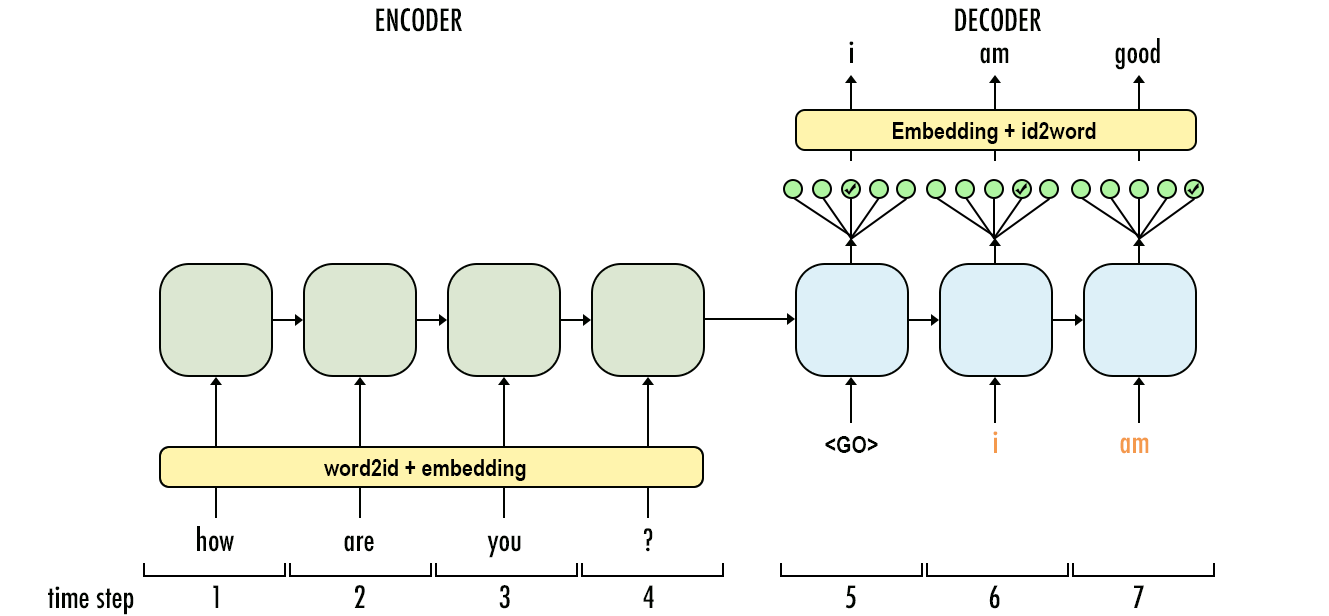

### 输入

In [19]:
inputs = tf.placeholder(tf.int32,[batch_size,seq_len])#应该是batch_size*单个输入的长度
labels = tf.placeholder(tf.int32,[batch_size,seq_len])#输出因为是输入的排序，所以是一样的尺寸
lr = tf.placeholder(tf.float32)

### Encoder
在Encoder层，我们首先需要对定义输入的tensor，同时要对字母进行Embedding，再输入到RNN层

假如我们有一个batch=2，sequence_length=5的样本，features = [[1,2,3,4,5],[6,7,8,9,10]]，使用
tf.contrib.layers.embed_sequence(features,vocab_size=n_words, embed_dim=10)

那么我们会得到一个2 x 5 x 10的输出，其中features中的每个数字都被embed成了一个10维向量。

官方关于tf.contrib.layers.embed_sequence()的解释如下：

Maps a sequence of symbols to a sequence of embeddings.
Typical use case would be reusing embeddings between an encoder and decoder.

In [21]:
#首先从input->embed,然后rnn
#embed使用 tf.contrib.layers.embed_sequence
source_vocab_size = len(source_letter_to_int)

embed = tf.contrib.layers.embed_sequence(inputs,source_vocab_size,encoding_embedding_size)

encoder_cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(rnn_size) for _ in range(num_layers)])
_,encoder_state = tf.nn.dynamic_rnn(encoder_cell,embed,dtype=tf.float32)

### Decoder
在Decoder端，我们主要要完成以下几件事情：
对target数据进行处理;
构造Decoder;
Embedding;
构造Decoder层;
构造输出层，输出层会告诉我们每个时间序列的RNN输出结果;
Training Decoder;
Predicting Decoder

#### 1. target数据处理
我们的target数据有两个作用：

在训练过程中，我们需要将我们的target序列作为输入传给Decoder端RNN的每个阶段，而不是使用前一阶段预测输出，这样会使得模型更加准确。（这就是为什么我们会构建Training和Predicting两个Decoder的原因，下面还会有对这部分的解释）。

需要用target数据来计算模型的loss。
我们首先需要对target端的数据进行一步预处理。在我们将target中的序列作为输入给Decoder端的RNN时，序列中的最后一个字母（或单词）其实是没有用的。我们来用下图解释：

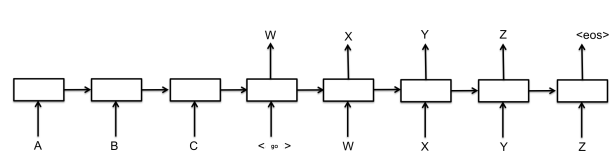

我们此时只看右边的Decoder端，可以看到我们的target序列是[go>, W, X, Y, Z, eos>]，其中go>，W，X，Y，Z是每个时间序列上输入给RNN的内容，我们发现，eos>并没有作为输入传递给RNN。因此我们需要将target中的最后一个字符去掉，同时还需要在前面添加go>标识，告诉模型这代表一个句子的开始。
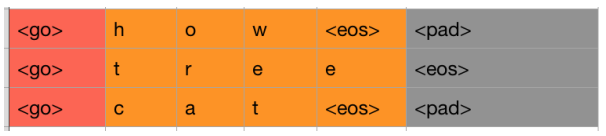
如上图，所示，红色和橙色为我们最终的保留区域，灰色是序列中的最后一个字符，我们把它删掉即可。

tf.fill(dims, value)参数会生成一个dims形状并用value填充的tensor。举个栗子：tf.fill([2,2], 7) => [[7,7], [7,7]]。tf.concat()会按照某个维度将两个tensor拼接起来。

In [24]:
import numpy as np
ending = tf.strided_slice(labels,[0,0],[batch_size,-1],[1,1])
decoder_input = tf.concat([tf.fill([batch_size,1],target_letter_to_int['<s>']),ending],1)

demon_outputs = np.reshape(range(batch_size*seq_len),(batch_size,seq_len))


In [32]:
sess = tf.InteractiveSession()
print("Targets")
print(demon_outputs[:2])
print("\nending")
print(sess.run(ending, {labels: demon_outputs})[:2])
print("\n")
print("Processed Decoding Input")
print(sess.run(decoder_input, {labels: demon_outputs})[:2])

Targets
[[ 0  1  2  3  4  5  6]
 [ 7  8  9 10 11 12 13]]

ending
[[ 0  1  2  3  4  5]
 [ 7  8  9 10 11 12]]


Processed Decoding Input
[[28  0  1  2  3  4  5]
 [28  7  8  9 10 11 12]]


#### 2. 构造Decoder
构造Decoder端的RNN单元。
构造输出层，从而得到每个时间序列上的预测结果。
构造training decoder。
构造predicting decoder。

注意，我们这里将decoder分为了training和predicting，这两个encoder实际上是共享参数的，也就是通过training decoder学得的参数，predicting会拿来进行预测。那么为什么我们要分两个呢，这里主要考虑模型的robust。

在training阶段，为了能够让模型更加准确，我们并不会把t-1的预测输出作为t阶段的输入，而是直接使用target data中序列的元素输入到Encoder中。而在predict阶段，我们没有target data，有的只是t-1阶段的输出和隐层状态。
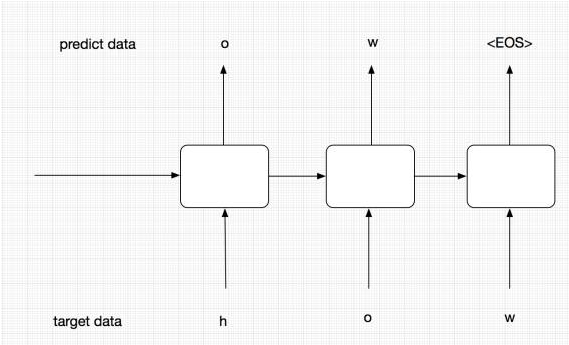

上面的图中代表的是training过程。在training过程中，我们并不会把每个阶段的预测输出作为下一阶段的输入，下一阶段的输入我们会直接使用target data，这样能够保证模型更加准确。
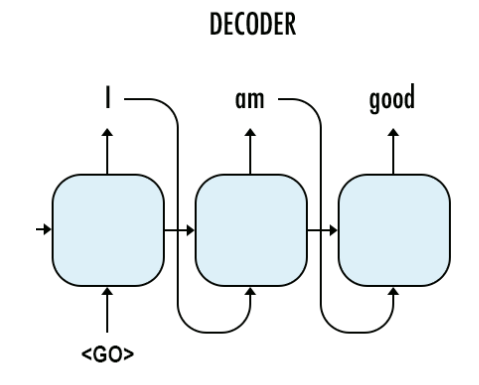
这个图代表我们的predict阶段，在这个阶段，我们没有target data，这个时候前一阶段的预测结果就会作为下一阶段的输入。
当然，predicting虽然与training是分开的，但他们是会共享参数的，training训练好的参数会供predicting使用。

In [37]:
target_vocab_size = len(target_letter_to_int)

#decoder embedding
decoder_embeding = tf.Variable(tf.random_uniform([target_vocab_size,decoding_embedding_size]))
decoder_embed = tf.nn.embedding_lookup(decoder_embeding,decoder_input)

#decoder RNN
decoder_cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(rnn_size) for _ in range(num_layers)])

#output layer
with tf.variable_scope("decoding") as decoding_scope:
    
 #   outputs,final_state = tf.nn.dynamic_rnn(decoder_cell,decoder_embed,dtype=tf.float32)
    
    output_fn = lambda x:tf.contrib.layers.fully_connected(x,target_vocab_size,None,scope=decoding_scope)

In [3]:
#Decoder during training
with tf.variable_scope("decoding") as decoding_scope:
    #Training Decoder
    training_decoder_fn = tf.contrib.seq2seq.simple_decoder_fn_train(encoder_state)
    train_pred,_ = tf.contrib.seq2seq.dynamic_rnn_decoder(decoder_cell,training_decoder_fn,deocder_embed,seq_len,scope=decoding_scope)
    
    #Apply output function
    train_logits = output_fn(train_pred)

In [ ]:
#Decoder during inference
with tf.variable_scope("decoding",reuse = True) as decoding_scope:
        # Inference Decoder
    infer_decoder_fn = tf.contrib.seq2seq.simple_decoder_fn_inference(
        output_fn, enc_state, dec_embeddings, target_letter_to_int['<s>'], target_letter_to_int['<\s>'], 
        sequence_length - 1, target_vocab_size)
    inference_logits, _, _ = tf.contrib.seq2seq.dynamic_rnn_decoder(dec_cell, infer_decoder_fn, scope=decoding_scope)

### 训练


In [22]:
#定义cost

In [ ]:
#train

### 预测